In [14]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])  # Assuming many-to-one
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_size).zero_(),
                  weight.new(self.num_layers, batch_size, self.hidden_size).zero_())
        return hidden

# Assuming the parameters for the LSTM model
input_size = 21
hidden_size = 128
num_layers = 3
output_size = 1

# Create an instance of LSTMModel
lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size)
lstm_model

LSTMModel(
  (lstm): LSTM(21, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [15]:
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
dfs = []
labels = []
pdf = pd.DataFrame()
for company in ['AAPL', 'AMD', 'AMZN', 'ASML','CSCO', 'GOOGL', 'INTC', 'MSFT', 'NVDA']:
    df_numerical = pd.read_csv('../dataset_transcript/EPS/'+company+'_EPS.csv')
    df_textural = pd.read_csv('../dataset_transcript/Transcripts/'+company+'_sentiment.csv')
    df_result = pd.read_csv('../dataset_transcript/Stock Values and Sector Index/'+company+'.csv')
    df_numerical['Date'] = pd.to_datetime(df_numerical['Date'])
    df_textural['Date'] = pd.to_datetime(df_textural['Date'])
    df_result['Date'] = pd.to_datetime(df_result['Date'])

    df_combined = pd.merge(df_textural, df_numerical, how="left", on=["Date"])

    mask = df_result['Date'].isin(df_combined['Date'])
    indices_of_interest = df_result.index[mask]
    
    previous_indices = indices_of_interest - 1
    previous_indices = previous_indices[previous_indices >= 0]
    df_previous = df_result.iloc[previous_indices].copy().reset_index(drop=True)
    df_previous = df_previous.rename(columns={col: 'prev_' + col for col in df_previous.columns})[['prev_High','prev_Low','prev_Close']]
    df_previous['Date'] = df_result.iloc[indices_of_interest].reset_index(drop=True)['Date']
    
    df_combined = pd.merge(df_combined, df_previous, how="left", on=["Date"])
    df_combined.fillna(0, inplace = True) 

    df_result = pd.merge(df_result, df_combined['Date'], how='right', on=["Date"])
    df_combined=df_combined.drop(columns=['Fiscal Quarter End', 'Date', 'prev_Date'])
    pdf=df_combined
    dfs.append(df_combined)
    labels.append(df_result['Close'])

train_size = 7
test_size = 2

train_features = torch.cat([torch.tensor(df.values).float() for df in dfs[:-test_size]])  # Assuming dfs[:-test_size] would work this way
train_labels = torch.cat([torch.tensor(label.values).float() for label in labels[:-test_size]])  # Similar handling for labels

test_features = torch.cat([torch.tensor(df.values).float() for df in dfs[-test_size:]])  # Assuming dfs[:-test_size] would work this way
test_labels = torch.cat([torch.tensor(label.values).float() for label in labels[-test_size:]])  # Similar handling for labels

train_features = train_features.view(train_size, -1, 21)
test_features = test_features.view(test_size, -1, 21)
train_labels = train_labels.view(train_size, -1) 
test_labels = test_labels.view(test_size, -1) 

# Create TensorDataset
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

# Create DataLoader
# Here batch_size is 1 because each batch is already pre-prepared
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # Shuffling batches, not within batches
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)  # Shuffling batches, not within batches

pdf.head()

,albert_positive,albert_negative,xlnet_positive,xlnet_negative,ernie_positive,ernie_negative,bert_positive,bert_negative,distilbert_positive,distilbert_negative,...,roberta_negative,Estimated EPS,Actual EPS,Revenue,prev_Open,prev_High,prev_Low,prev_Close,prev_Adj Close,prev_Volume
0,0.591452,0.408548,0.618174,0.381825,0.600285,0.399715,0.489602,0.510398,0.493453,0.506547,...,0.465384,0.08,0.10,1305,36.070000,36.459999,35.869999,36.060001,35.421799,8204400
1,0.579308,0.420692,0.620448,0.379552,0.595101,0.404899,0.488267,0.511733,0.492794,0.507206,...,0.465053,0.08,0.09,1401,26.100000,27.030001,26.020000,26.990000,26.416088,12133800
2,0.574248,0.425752,0.644800,0.355200,0.599681,0.400319,0.480340,0.519660,0.493156,0.506844,...,0.464274,0.17,0.21,1937,104.339996,104.400002,102.309998,102.769997,101.679794,9131000
3,0.583340,0.416660,0.660477,0.339523,0.597524,0.402476,0.483067,0.516933,0.493987,0.506013,...,0.465121,0.22,0.23,2579,152.500000,152.949997,148.309998,150.070007,149.608459,10497000
4,0.577660,0.422340,0.656823,0.343177,0.594794,0.405206,0.481238,0.518762,0.492482,0.507518,...,0.465417,0.34,0.39,3105,270.010010,272.799988,268.450012,272.540009,272.171417,9366100


In [16]:
import matplotlib.pyplot as plt

# Assuming you have a function to generate predictions
def generate_predictions(data, model):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    hidden = model.init_hidden(1) 

    with torch.no_grad():  
        for i in range(data.size(0)):
            output, hidden = model(data[i:i+1].unsqueeze(0), hidden)
            hidden = (hidden[0].detach(), hidden[1].detach())  # Detach hidden state
            predictions.append(output.squeeze().item())  # Collect the prediction
    return predictions

In [17]:
from tqdm import tqdm

def train_each_model(loader, model, optimizer, criterion, epochs):
    model.train()
    l_loss = list()
    for epoch in tqdm(range(epochs)):
        total_loss = 0

        for data, labels in loader:
            data = data.squeeze(0)  # Assuming data comes in as [1, sequence, features]
            labels = labels.squeeze(0)  # Assuming labels come in as [1, sequence]
            hidden = model.init_hidden(1) 
            for i in range(data.size(0)):  # Iterate over each time step
                optimizer.zero_grad()
                
                # Forward pass 
                output, hidden = model(data[i:i+1].unsqueeze(0), hidden)
                
                # Detach hidden states; otherwise, the graph will try to backpropagate through all previous steps
                hidden = (hidden[0].detach(), hidden[1].detach())
                
                # Compute loss
                loss = criterion(output, labels[i:i+1])
                loss.backward()  # Compute gradients
                optimizer.step()  # Update model parameters
                
                total_loss += loss.item()
        
        l_loss.append(total_loss)
        if (epoch+1) %(epochs//10) == 0:
            print(f'Epoch {epoch+1}, Average Loss: {total_loss / len(loader)}')

    plt.plot(l_loss, linestyle='-', color='b')  
    plt.xlabel('Epochs') 
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.show()


def train_whole_model(loader, model, optimizer, criterion, epochs):
    model.train()
    l_loss = list()
    for epoch in tqdm(range(epochs)):
        total_loss = 0

        for data, labels in loader:
            data = data.squeeze(0)  # Assuming data comes in as [1, sequence, features]
            labels = labels.squeeze(0)  # Assuming labels come in as [1, sequence]
            hidden = model.init_hidden(1) 
            for i in range(data.size(0)):  # Iterate over each time step
                optimizer.zero_grad()
                
                # Forward pass 
                output, hidden = model(data[i:i+1].unsqueeze(0), hidden)
                
                # Detach hidden states; otherwise, the graph will try to backpropagate through all previous steps
                hidden = (hidden[0].detach(), hidden[1].detach())
                
                # Compute loss
                loss = criterion(output, labels[i:i+1])
                total_loss += loss

        total_loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters
        
        l_loss.append(total_loss.item())
        if (epoch+1) %(epochs//10) == 0:
            print(f'Epoch {epoch+1}, Average Loss: {total_loss / len(loader)}')

    plt.plot(l_loss, linestyle='-', color='b')  
    plt.xlabel('Epochs') 
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]/Users/jiaruiz/miniforge3/envs/6998/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 5/50 [00:01<00:12,  3.63it/s]

Epoch 5, Average Loss: 7750042.147457668


 20%|██        | 10/50 [00:02<00:10,  3.68it/s]

Epoch 10, Average Loss: 7359082.936340332


 30%|███       | 15/50 [00:04<00:09,  3.75it/s]

Epoch 15, Average Loss: 7304411.144165039


 40%|████      | 20/50 [00:05<00:07,  3.78it/s]

Epoch 20, Average Loss: 7306127.4982386995


 50%|█████     | 25/50 [00:06<00:06,  3.77it/s]

Epoch 25, Average Loss: 7302082.150809152


 60%|██████    | 30/50 [00:08<00:05,  3.90it/s]

Epoch 30, Average Loss: 7343848.921635219


 70%|███████   | 35/50 [00:09<00:03,  3.94it/s]

Epoch 35, Average Loss: 7297987.335065569


 80%|████████  | 40/50 [00:10<00:02,  3.93it/s]

Epoch 40, Average Loss: 7356170.712236677


 90%|█████████ | 45/50 [00:11<00:01,  4.22it/s]

Epoch 45, Average Loss: 7345685.798339844


100%|██████████| 50/50 [00:12<00:00,  3.89it/s]

Epoch 50, Average Loss: 7414587.549739225


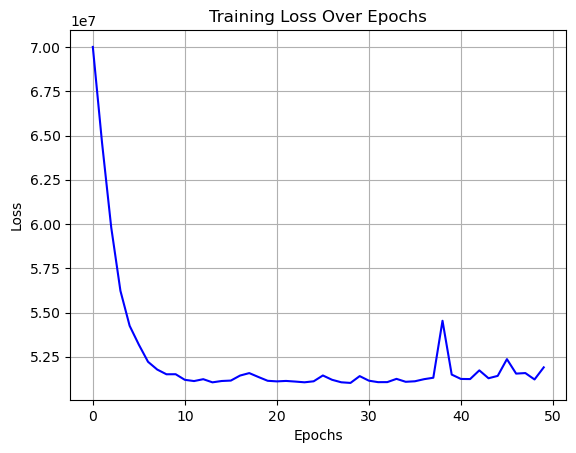

 12%|█▏        | 12/100 [00:01<00:08, 10.29it/s]

Epoch 10, Average Loss: 7177273.5


 22%|██▏       | 22/100 [00:02<00:07, 10.97it/s]

Epoch 20, Average Loss: 7063698.5


 32%|███▏      | 32/100 [00:02<00:06, 11.09it/s]

Epoch 30, Average Loss: 6246380.0


 42%|████▏     | 42/100 [00:03<00:05, 11.08it/s]

Epoch 40, Average Loss: 5275379.5


 52%|█████▏    | 52/100 [00:04<00:04, 11.11it/s]

Epoch 50, Average Loss: 5081265.0


 62%|██████▏   | 62/100 [00:05<00:03, 10.79it/s]

Epoch 60, Average Loss: 4892373.0


 72%|███████▏  | 72/100 [00:06<00:02, 10.99it/s]

Epoch 70, Average Loss: 4679996.5


 82%|████████▏ | 82/100 [00:07<00:01, 11.20it/s]

Epoch 80, Average Loss: 4552246.5


 92%|█████████▏| 92/100 [00:08<00:00, 11.16it/s]

Epoch 90, Average Loss: 4439355.0


100%|██████████| 100/100 [00:09<00:00, 10.93it/s]


Epoch 100, Average Loss: 4332580.5


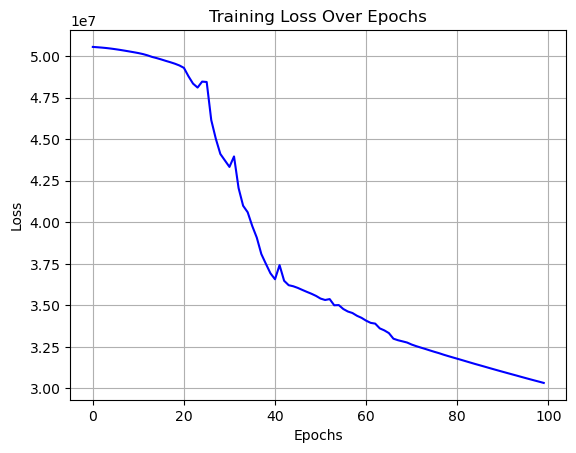

In [18]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2)
train_each_model(train_loader, lstm_model, optimizer, criterion, epochs=50)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2)
train_whole_model(train_loader, lstm_model, optimizer, criterion, epochs=100)

 10%|█         | 50/500 [00:10<01:31,  4.93it/s]

Epoch 50, Average Loss: 2543078.5746734855


 20%|██        | 100/500 [00:20<01:19,  5.00it/s]

Epoch 100, Average Loss: 1826452.804946923


 30%|███       | 150/500 [00:30<01:10,  4.95it/s]

Epoch 150, Average Loss: 1667244.319328951


 40%|████      | 201/500 [00:40<01:00,  4.93it/s]

Epoch 200, Average Loss: 1550544.3524123132


 50%|█████     | 250/500 [00:53<01:04,  3.89it/s]

Epoch 250, Average Loss: 1476050.970920367


 60%|██████    | 300/500 [01:06<00:52,  3.82it/s]

Epoch 300, Average Loss: 1426027.7481722885


 70%|███████   | 350/500 [01:19<00:39,  3.81it/s]

Epoch 350, Average Loss: 1230820.0470766064


 80%|████████  | 400/500 [01:32<00:25,  3.85it/s]

Epoch 400, Average Loss: 1316664.2385329795


 90%|█████████ | 450/500 [01:45<00:10,  4.55it/s]

Epoch 450, Average Loss: 1158653.3800891181


100%|██████████| 500/500 [01:55<00:00,  4.31it/s]

Epoch 500, Average Loss: 1103028.7969380144


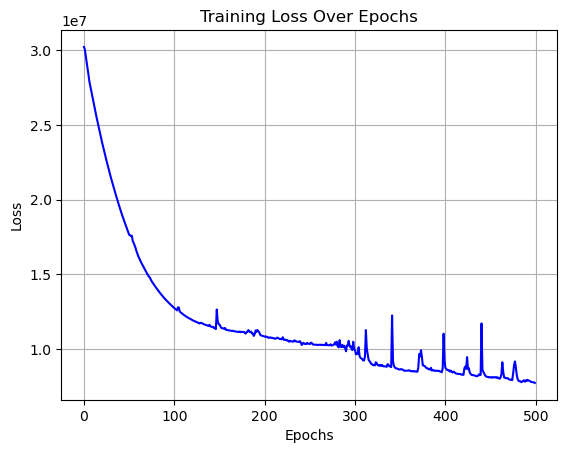

 10%|█         | 102/1000 [00:09<01:22, 10.91it/s]

Epoch 100, Average Loss: 999769.5


 20%|██        | 200/1000 [00:18<01:19, 10.10it/s]

Epoch 200, Average Loss: 898670.6875


 30%|███       | 302/1000 [00:28<01:05, 10.64it/s]

Epoch 300, Average Loss: 903292.6875


 40%|████      | 402/1000 [00:37<00:56, 10.57it/s]

Epoch 400, Average Loss: 748681.0625


 50%|█████     | 502/1000 [00:47<00:47, 10.50it/s]

Epoch 500, Average Loss: 691407.5


 60%|██████    | 602/1000 [00:56<00:37, 10.49it/s]

Epoch 600, Average Loss: 739638.875


 70%|███████   | 702/1000 [01:06<00:29, 10.14it/s]

Epoch 700, Average Loss: 602671.9375


 80%|████████  | 802/1000 [01:15<00:18, 10.96it/s]

Epoch 800, Average Loss: 564846.8125


 90%|█████████ | 900/1000 [01:25<00:09, 10.16it/s]

Epoch 900, Average Loss: 552864.6875


100%|██████████| 1000/1000 [01:34<00:00, 10.63it/s]


Epoch 1000, Average Loss: 573209.6875


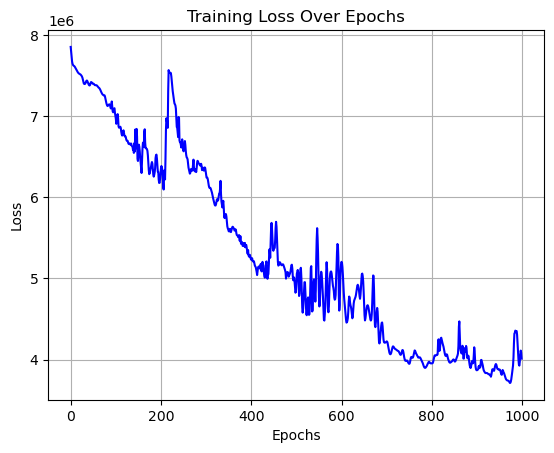

In [19]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
train_each_model(train_loader, lstm_model, optimizer, criterion, epochs=500)

optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
train_whole_model(train_loader, lstm_model, optimizer, criterion, epochs=1000)

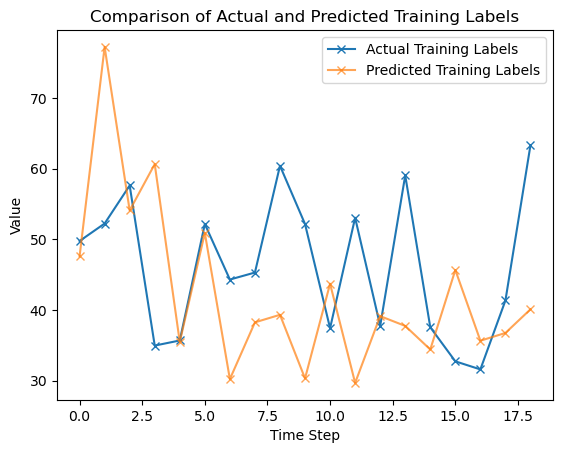

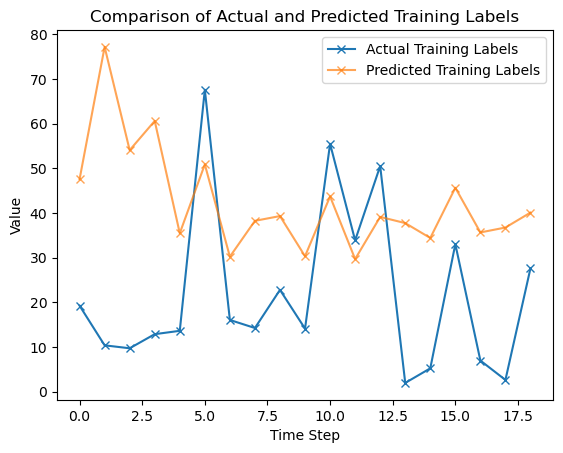

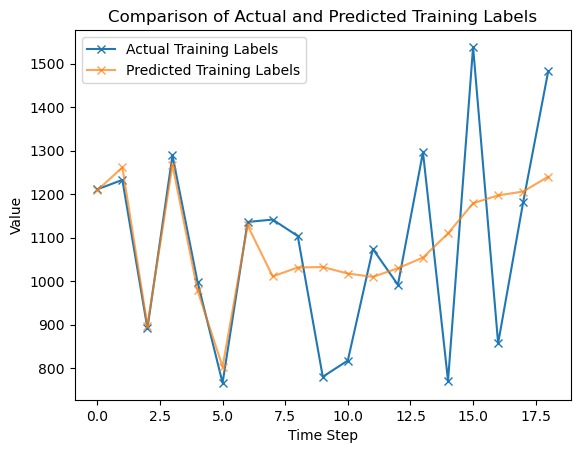

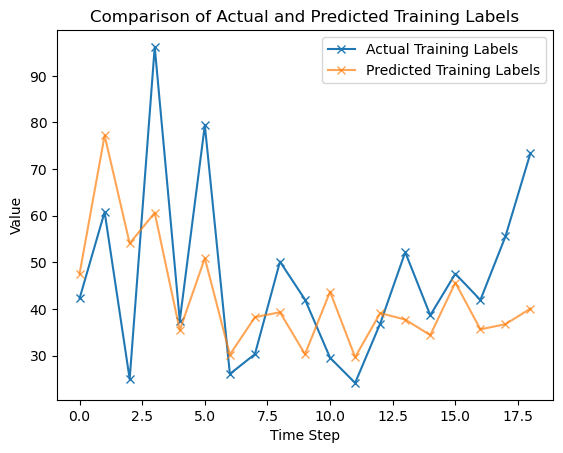

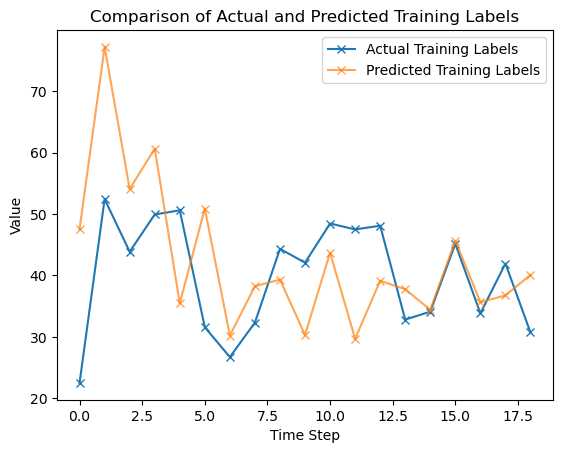

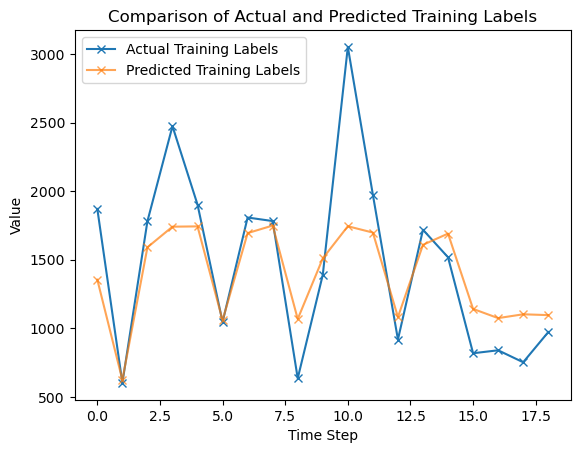

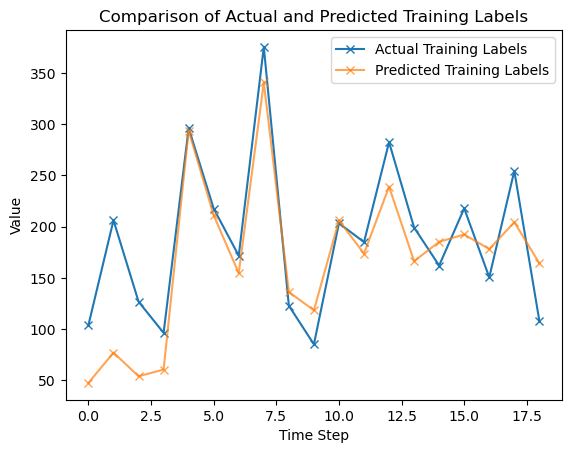

In [20]:
for data, labels in train_loader:
    train_predictions = generate_predictions(data.view(-1, 21), lstm_model)
    # Convert train_labels to a list or a numpy array if it's a tensor
    train_labels_list = labels.squeeze().tolist()  # Adjust based on your actual format

    # Plot the actual and predicted values
    plt.plot(train_labels_list, marker='x', label='Actual Training Labels')
    plt.plot(train_predictions, marker='x', label='Predicted Training Labels', alpha=0.7)
    plt.title('Comparison of Actual and Predicted Training Labels')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

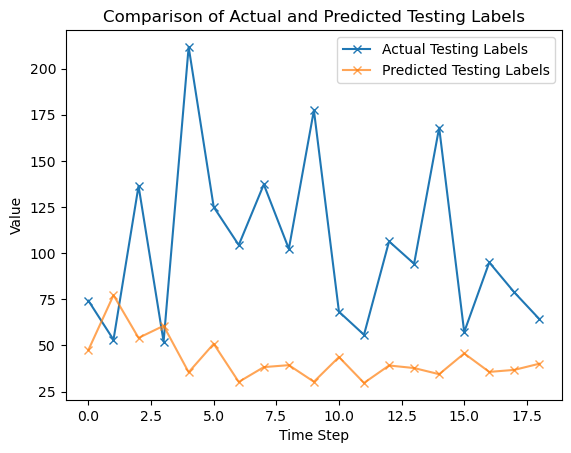

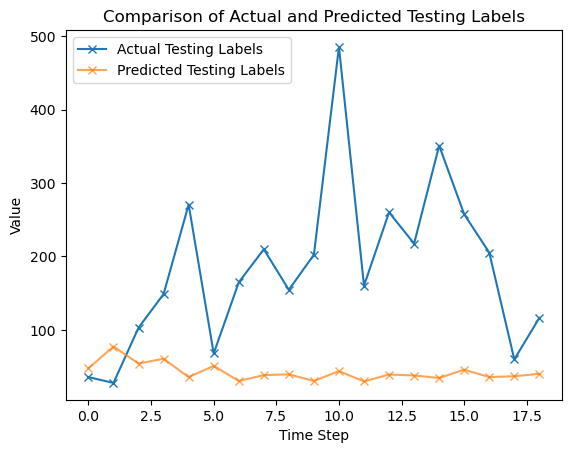

In [21]:
for data, labels in test_loader:
    test_predictions = generate_predictions(data.view(-1, 21), lstm_model)
    # Convert train_labels to a list or a numpy array if it's a tensor
    test_labels_list = labels.squeeze().tolist()  # Adjust based on your actual format

    # Plot the actual and predicted values
    plt.plot(test_labels_list, marker='x', label='Actual Testing Labels')
    plt.plot(test_predictions, marker='x', label='Predicted Testing Labels', alpha=0.7)
    plt.title('Comparison of Actual and Predicted Testing Labels')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()